In [1]:
## LSTM without preprocessing
import pandas as pd
import numpy as np
import torch
from torch import cuda
import random
import os
import re
import string
import torch
from torch import nn
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from matplotlib import pyplot as plt
print(torch.__version__)

1.11.0+cu113


In [5]:
# data import
#Training_data
train_data = pd.read_csv(r"/content/train.csv")
print(train_data)
#test data import
test_data = pd.read_csv(r"/content/test.csv")
print(test_data)

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UT

In [6]:
print(train_data.columns)
train_data.head(5)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
#create Target
train_label = train_data.target.to_numpy()
y_train = train_label.reshape(-1)
train_data.drop(['id', 'keyword', 'location', 'target'], axis=1, inplace=True)
test_data.drop(['id', 'keyword', 'location'], axis=1, inplace=True)
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()
x_train = train_data.reshape(-1)
x_test = test_data.reshape(-1)

In [8]:
#Model constant
max_features = 20000
embedding_dim = 128
max_len = 50

In [9]:
from keras.layers import*
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=max_len)

In [11]:
vectorize_layer.adapt(train_data)
import tensorflow as tf
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [12]:
from keras.metrics import AUC
from keras import optimizers, losses
def build_model():

    text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
    x = vectorize_layer(text_input)
    x = Embedding(max_features + 1, embedding_dim)(x)
    x = Dropout(0.5)(x)

    x1 = Bidirectional(LSTM(units=128, return_sequences=True))(x)
    x2 = Bidirectional(LSTM(units=64, return_sequences=True))(x1)

    z2 = Bidirectional(GRU(units=128, return_sequences=True))(x)
    z3 = Bidirectional(GRU(units=64, return_sequences=True))(z2)
    c = Concatenate(axis=2)([x2, z3])

    x3 = Bidirectional(LSTM(units=128, return_sequences=True))(c)
    # Conv1D + global max pooling

    x = GlobalMaxPooling1D()(x3)

    # We add a vanilla hidden layer:
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)

    # We project onto a single unit output layer, and squash it with a sigmoid:
    predictions = Dense(1, activation="sigmoid", name="predictions")(x)

    model = tf.keras.Model(text_input, predictions)

    # Compile the model with binary crossentropy loss and an adam optimizer.

    model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.rmsprop_v2.RMSprop(learning_rate=0.01), metrics=[AUC(name = 'auc')])
    #model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.rmsprop_v2.RMSprop(learning_rate=0.01), metrics=['F1'])
    return model


In [13]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 50)          0           ['text[0][0]']                   
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          (None, 50, 128)      2560128     ['text_vectorization[0][0]']     
                                                                                                  
 dropout (Dropout)              (None, 50, 128)      0           ['embedding[0][0]']          

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [15]:
from keras.callbacks import *

lr = ReduceLROnPlateau(monitor="val_auc", mode='max', factor=0.7, patience=4, verbose=False)
es = EarlyStopping(monitor='val_auc',mode='max', patience=10, verbose=False,restore_best_weights=True)

history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=4, batch_size=256,
                    callbacks=[es,lr])

Epoch 1/4
24/24 [==============================] - 114s 4s/step - loss: 1.1843 - auc: 0.5026 - val_loss: 0.6870 - val_auc: 0.5305 - lr: 0.0100
Epoch 2/4
24/24 [==============================] - 76s 3s/step - loss: 0.6593 - auc: 0.6383 - val_loss: 0.5318 - val_auc: 0.8024 - lr: 0.0100
Epoch 3/4
24/24 [==============================] - 75s 3s/step - loss: 0.4565 - auc: 0.8620 - val_loss: 0.5612 - val_auc: 0.8085 - lr: 0.0100
Epoch 4/4
24/24 [==============================] - 79s 3s/step - loss: 0.3396 - auc: 0.9240 - val_loss: 0.6868 - val_auc: 0.8129 - lr: 0.0100


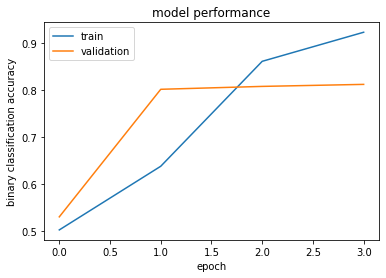

In [17]:
def plot_hist(hist, metric='auc'):
    plt.plot(hist.history[metric])
    plt.plot(hist.history["val_" + metric])
    plt.title(f"model performance")
    plt.ylabel("binary classification accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return
plot_hist(hist=history)